In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "../../Dataset/SYNTHIA-SF/"

CLASSES = [
        "road", "sidewalk", "building", "pole", "traffic light", 
        "traffic sign", "terrain", "person", "rider", "car", "truck", 
        "bus", "train", "motorcycle", "bicycle"
    ] # all synthia dataset class

In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from pathlib import Path

In [5]:
class SynthiaDataset(Dataset):

    CLASSES = [
        "void", "road", "sidewalk", "building", "wall", "fence", "pole", "traffic light", 
        "traffic sign", "vegetation", "terrain", "sky", "person", "rider", "car", "truck", 
        "bus", "train", "motorcycle", "bicycle", "road lines", "other", "road works"
    ]
    
    def __init__(self, path="../../Dataset/SYNTHIA-SF", classes=None, augmentation=None, preprocessing=None,):
        self.rootdir = Path(path)
        # get list of file
        self.left_imgs, self.left_gts = self.prepare_data(path) 
    
        # convert str names to class values on masks
        if classes == None:
            classes = self.CLASSES # if no value, assign all classes
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, index):
        """Get sample from dataset"""
        # read data
        # NOTE: using opencv image reader
        # TODO: should be converted to PIL image?
        image = cv2.imread(str(self.left_imgs[index]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(str(self.left_gts[index]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = mask[...,0] # Label on RED channel
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        """Return dataset size"""
        return len(self.left_imgs)

    def prepare_data(self, path):
        """Return list of all images in dataset"""
        left_imgs = list(self.rootdir.glob("*/RGBLeft/*.png"))
        left_gts = list(self.rootdir.glob("*/GTLeft/*.png"))
        
        return left_imgs, left_gts

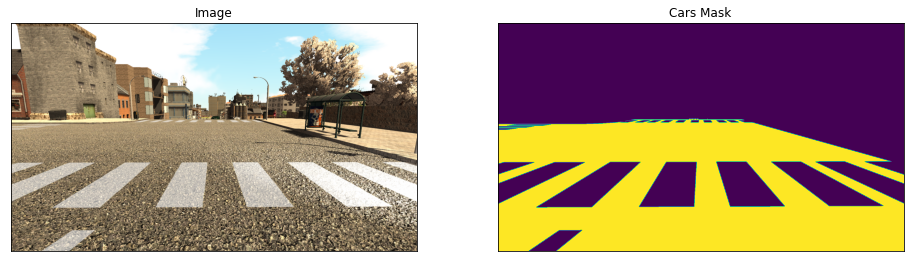

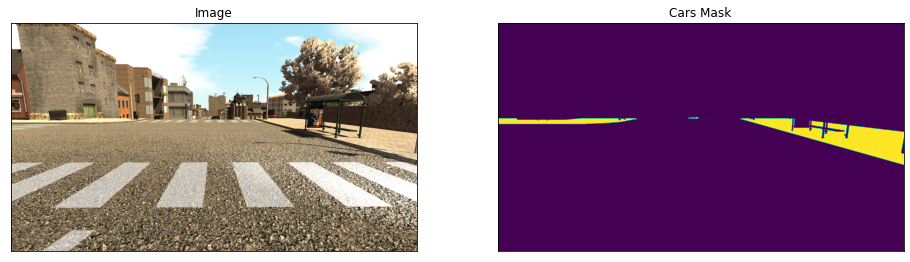

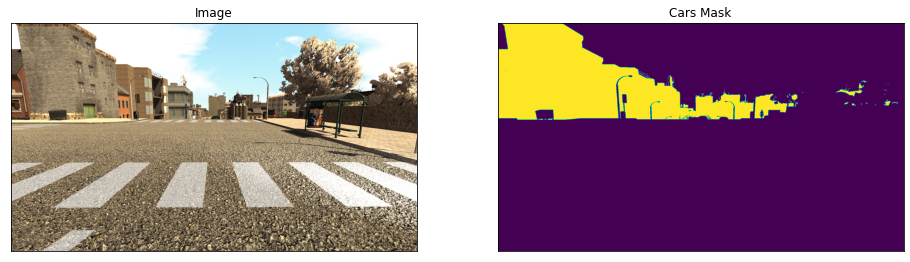

In [6]:
# Lets look at data we have
dataset = SynthiaDataset(classes=CLASSES)

image, mask = dataset[3] # get some sample
total_class = mask.shape[-1]

for i in range(3):
    visualize(
        image=image, 
        cars_mask=mask[...,i].squeeze(),
    )

### Augmentation

In [7]:
import albumentations as albu

In [8]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(1088, 1920)
        #albu.PadIfNeeded(320, 320)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

D:\anaconda3\envs\affective\lib\site-packages\albumentations\imgaug\transforms.py:252: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
D:\anaconda3\envs\affective\lib\site-packages\albumentations\imgaug\transforms.py:375: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
D:\anaconda3\envs\affective\lib\site-packages\albumentations\augmentations\transforms.py:1744: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
D:\anaconda3\envs\affective\lib\site-packages\albumentations\imgaug\transforms.py:222: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
D:\anaconda3\envs\a

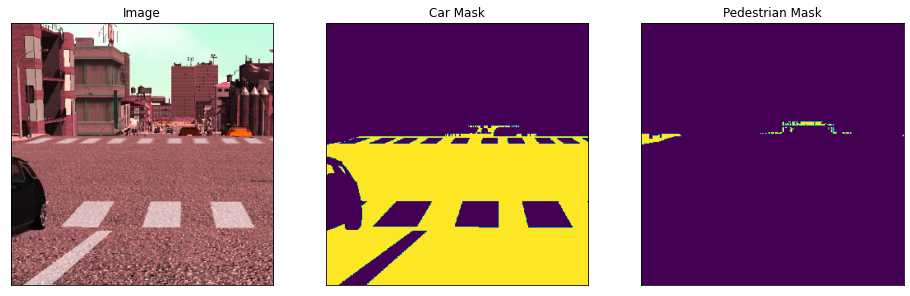

(320, 320)


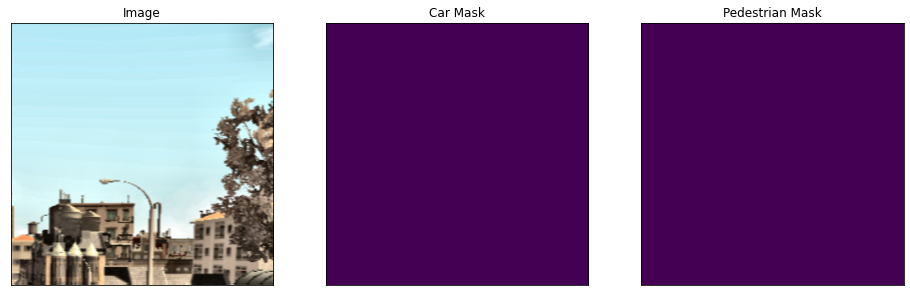

(320, 320)


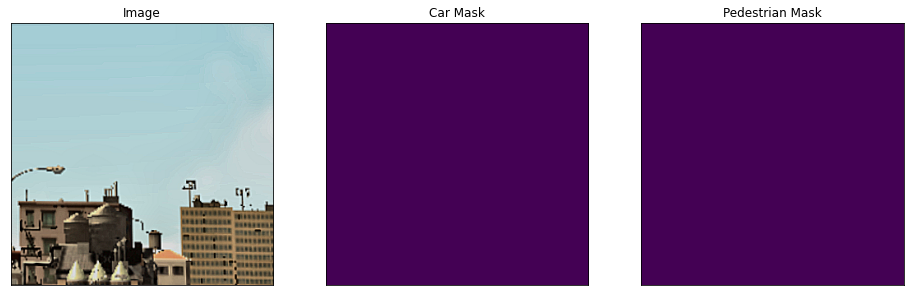

(320, 320)


In [9]:
#### Visualize resulted augmented images and masks
augmented_dataset = SynthiaDataset(
    augmentation=get_training_augmentation(), 
    classes=CLASSES,
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, car_mask=mask[...,0].squeeze(), pedestrian_mask=mask[...,1].squeeze())
    print(mask[...,0].shape)

### Create model and train

In [10]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [11]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = CLASSES
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3Plus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
print(model.parameters)

<bound method Module.parameters of DeepLabV3Plus(
  (encoder): MobileNetV2Encoder(
    (features): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvNormActivation(
        

In [12]:
train_dataset = SynthiaDataset(
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = SynthiaDataset(
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)

In [13]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.7),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
# train model for 40 epochs
max_score = 0
EPOCHS = 10
for i in range(0, EPOCHS):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    #valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    #if max_score < valid_logs['iou_score']:
    if max_score < train_logs['iou_score']:
        #max_score = valid_logs['iou_score']
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 7:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-4!')

### Test best model

In [14]:
import torch
import numpy as np

MODEL_NAME = "best_model.pth"
# load best saved checkpoint
best_model = torch.load(MODEL_NAME)

In [15]:
# create test dataset
test_dataset = SynthiaDataset(
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

image, mask = test_dataset[0]
print(image.shape)

test_dataloader = DataLoader(test_dataset)

(3, 1088, 1920)


In [16]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 2224/2224 [18:17<00:00,  2.03it/s, dice_loss - 0.1704, iou_score - 0.7335]


### Visualize prediction

In [18]:
# test dataset without transformations for image visualization
test_dataset_vis = SynthiaDataset(
    classes=CLASSES,
)

In [ ]:
n = np.random.choice(len(test_dataset))
image_vis = test_dataset[n][0].astype('uint8')
print(image_vis.shape)
gt_vis = test_dataset[n][1].astype('uint8')
print(gt_vis.shape)

In [ ]:
image_vis_test, gt_vis_test = test_dataset_vis[n]
print(image_vis_test.shape, gt_vis_test.shape)

In [ ]:
#visualize(image_vis=image_vis) # test dataset cannot be displayed because already pre_processed for testing
visualize(image_vis_test=image_vis_test)

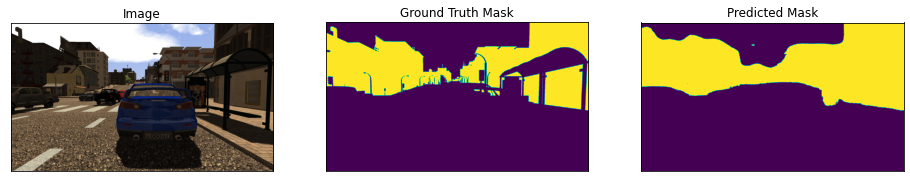

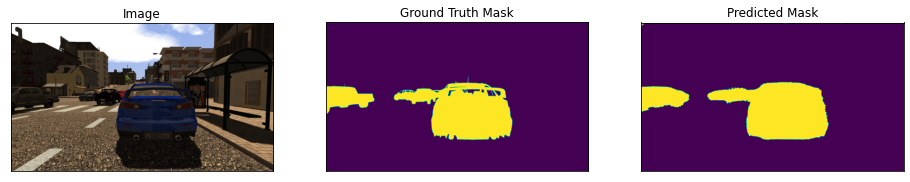

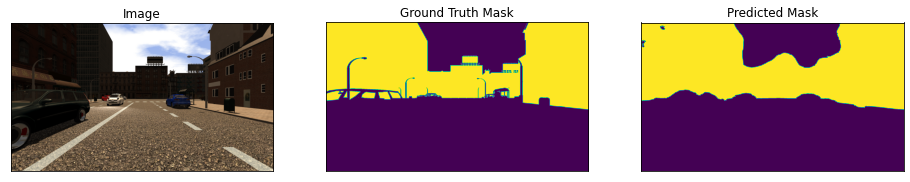

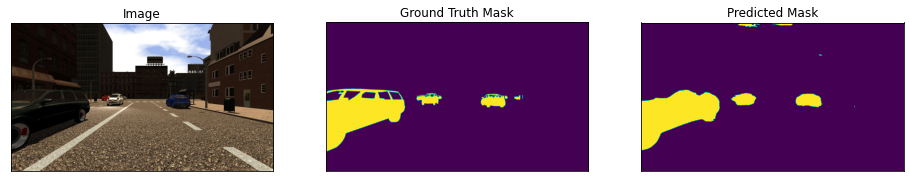

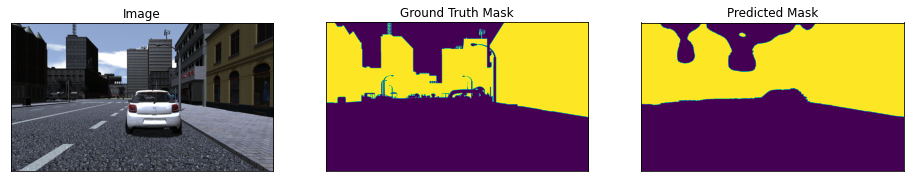

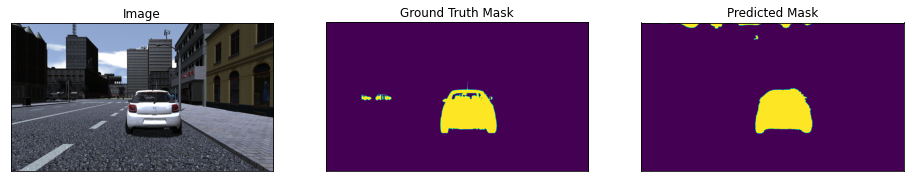

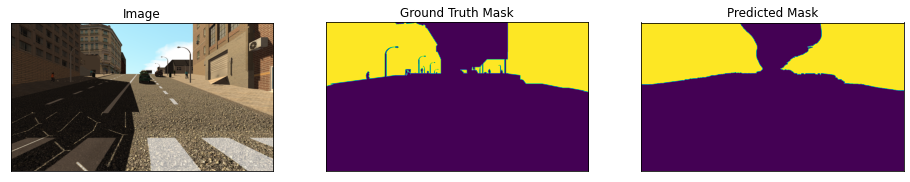

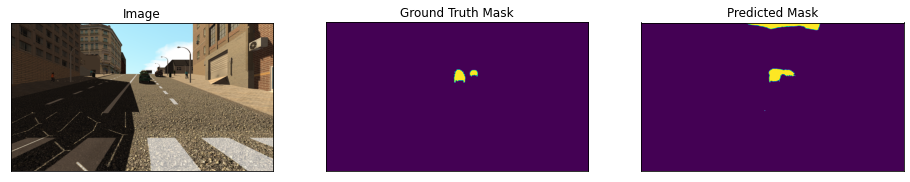

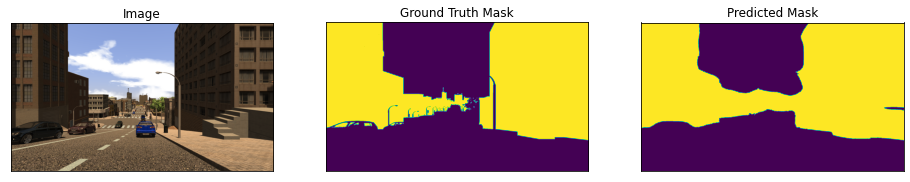

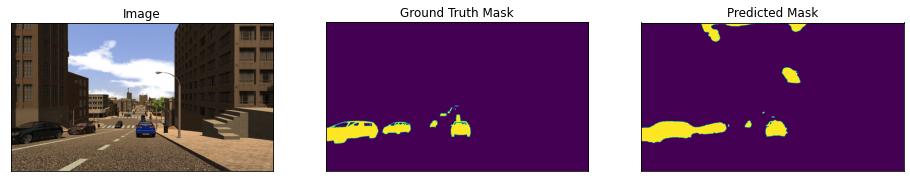

In [20]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    # BUILDING   
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[2,...].squeeze(), 
        predicted_mask=pr_mask[2,...].squeeze()
    )
    # CAR
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask[9,...].squeeze(), 
        predicted_mask=pr_mask[9,...].squeeze()
    )

### Visualize segmentation in one image

In [ ]:
# Visuaize segmentation in one image
